<font size="5">**A Quantum Neural Network Regression for Modeling Lithium-ion Battery Capacity Degradation**</font> 

***

Developer: Anh Phuong Ngo (Roger Ngo)

This repository contains the supplementary material for the paper entitled "A Quantum Neural Network Regression for Modeling Lithium-ion Battery Capacity Degradation" published on IEEE Xplore: https://ieeexplore.ieee.org/document/10173794

In the repsitory, the code of following sections are provided:
1. Data collection for 12 Li-ion batteries (NASA)
2. Quantum neural network (QNN) Regression model
3. Implementation of QNN on Qulacs simulator
4. Visualization of Quantum circuit

News: In the 2nd version of QNN Regression, which will be uploaded with our upcoming publication in Variational Quantum Circuit, we will use a different model and platform.

# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

from mat2json import loadMat
from util import getBatteryCapacity, getChargingValues, getDischargingValues, getDataframe, series_to_supervised, rollingAverage

In [3]:
#Ambient temp 24
B0005 = loadMat('B0005.mat')
B0006 = loadMat('B0006.mat')
B0007 = loadMat('B0007.mat')
B0018 = loadMat('B0018.mat')

#Ambient temp 43
B0029 = loadMat('B0029.mat')
B0030 = loadMat('B0030.mat')
B0031 = loadMat('B0031.mat')
B0032 = loadMat('B0032.mat')

#Ambient temp 4
B0041 = loadMat('B0041.mat')
B0053 = loadMat('B0053.mat')
B0054 = loadMat('B0054.mat')
B0055 = loadMat('B0055.mat')
B0056 = loadMat('B0056.mat')

In [4]:
B0005_capacity = getBatteryCapacity(B0005)
B0006_capacity = getBatteryCapacity(B0006)
B0007_capacity = getBatteryCapacity(B0007)
B0018_capacity = getBatteryCapacity(B0018)

B0029_capacity = getBatteryCapacity(B0029)
B0030_capacity = getBatteryCapacity(B0030)
B0031_capacity = getBatteryCapacity(B0031)
B0032_capacity = getBatteryCapacity(B0032)

B0053_capacity = getBatteryCapacity(B0053)
B0054_capacity = getBatteryCapacity(B0054)
B0055_capacity = getBatteryCapacity(B0055)
B0056_capacity = getBatteryCapacity(B0056)

# Get data from B0006, B0007, B0018

In [5]:
dfB0006 = getDataframe(B0006)
dfB0007 = getDataframe(B0007)
dfB0018 = getDataframe(B0018)

#Get 10 first sample data
dfB0006.head(10)

,cycle,capacity,max_discharge_temp,max_charge_temp
0,1,2.035338,39.162987,27.355870
1,2,2.025140,39.246203,31.874973
2,3,2.013326,38.999202,32.149173
3,4,2.013285,38.843628,32.017074
4,5,2.000528,38.977989,31.921070
5,6,2.013899,38.839899,32.032402
6,7,2.013101,39.046108,32.002633
7,8,1.968790,38.875075,32.204361
8,9,1.968166,38.726054,32.089091
9,10,1.957231,38.986297,31.997731


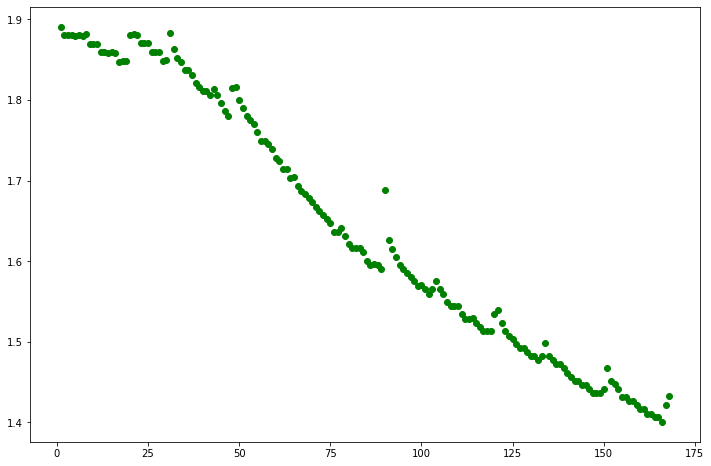

In [6]:
# You can choose one of the batteries: B0006, B0007, and B0018. In this case, I selected B0007
X = dfB0007['cycle']
Y = dfB0007['capacity']

# Plotting for capacity
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.scatter(X, Y, color='green', label='Battery')

---
# Data preparation

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [8]:
lst_x, lst_y = rollingAverage(X_train, y_train)
d = {'X_train':X_train.values,'y_train':y_train.values}
d = pd.DataFrame(d)
d = d[~d['X_train'].isin(lst_x)]
X_train = d['X_train']
y_train = d['y_train']

In [9]:
col1 = "X"
col2 = "Y"
col3 = "lstx"
col4 = "lsty"
data = pd.DataFrame({col1:X_train,col2:y_train})
data.to_excel('sample_data.xlsx', sheet_name='sheet1', index=False)
data = pd.DataFrame({col3:lst_x,col4:lst_y})
data.to_excel('sample2_data.xlsx', sheet_name='sheet1', index=False)

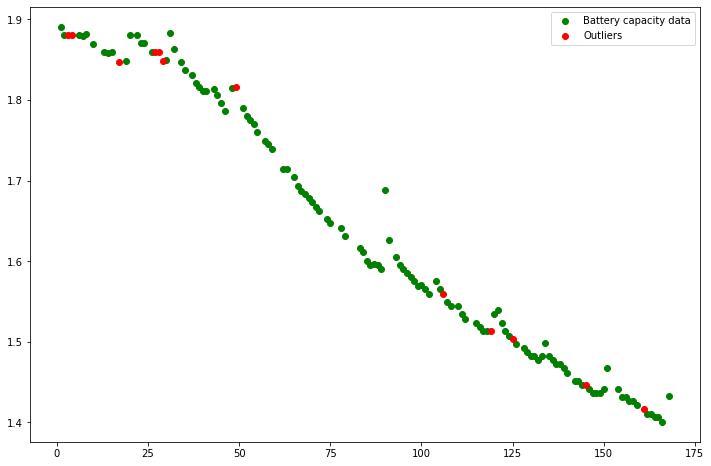

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.scatter(X_train, y_train, color='green', label='Battery capacity data')
ax.scatter(lst_x, lst_y, color='red', label='Outliers')
ax.legend()

---
# QNN Regressor

## Skitlearn and Skqulacs libraries

In [11]:
import pandas as pd
from sklearn import datasets

## Data pre-processing

In [12]:
x_test = X.values.reshape(-1, 1)
y_test = Y.values.reshape(-1, 1)

X_train = X_train.values.reshape(-1, 1)
y_train = y_train.values.reshape(-1, 1)

## Prediction

In [13]:
from skqulacs.circuit.pre_defined import create_qcl_ansatz # Prefer to choose this circuit
from skqulacs.circuit import create_ibm_embedding_circuit
from skqulacs.qnn.solver import Bfgs, Adam, NelderMead
from numpy.random import default_rng

In [14]:
from skqulacs.qnn import QNNRegressor

n_qubit = 5
depth = 3
time_step = 0.5#0.305
solver = Bfgs() #Adam()  #NelderMead() #Bfgs()
maxiter= 200
#cost: Literal['mse'] = 'mse', do_x_scale: bool = True, do_y_scale: bool = True,
circuit = create_qcl_ansatz(n_qubit, depth, time_step, 0)
model = QNNRegressor(circuit, solver,  cost= 'mse', do_x_scale = True, do_y_scale = True, x_norm_range =0.6, y_norm_range = 0.7)
opt_loss, theta = model.fit(X_train, y_train, maxiter)
print("trained parameters", theta)
print("loss", opt_loss)

trained parameters [ 4.96272375  1.55657372  0.87987256 -0.86910358  4.91228465  6.30919374
  3.73744978  5.38391152  3.45782339  4.85391672  4.83274296  0.71503875
  4.90466679  0.52037331  4.05435364  1.93631892  4.8964359   4.02768434
  1.37920314  2.94982068  0.04206019  0.55293113  4.78615381  4.53980843
  3.98909955  2.30818217  5.79735621  6.62102457  4.6675766   4.41715754
  4.59038183  2.24726386  0.55678095  4.53324494  3.30089856  1.94930719
  3.05259359  5.58881689  5.8687685   2.24809352  3.59102784  2.02236503
  3.73409722  2.12315885  2.46061475]
loss 0.0019310608213738989


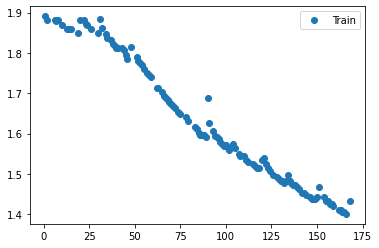

In [15]:
plt.plot(X_train, y_train, "o", label="Train")
plt.legend()
plt.show()

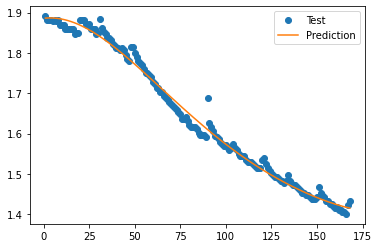

In [16]:
import matplotlib.pyplot as plt

#print('x_test = ',x_test.flatten())
#print('y_test = ',y_test.flatten())

#y_pred = qnn.predict(x_test)
y_pred = model.predict(x_test)
#"""
plt.plot(x_test, y_test, "o", label="Test")
plt.plot(np.sort(np.array(x_test).flatten()), np.array(y_pred)[np.argsort(np.array(x_test).flatten())], label="Prediction")
plt.legend()
plt.show()
#"""

In [20]:
# RMSE and MAPE
rmse = 0

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

print('qubit = ',n_qubit,', depth = ', depth)
print('RMSE = ',rmse(y_pred,y_test))

from sklearn.metrics import mean_absolute_percentage_error
print('MAPE = ',mean_absolute_percentage_error(y_test, y_pred))

qubit =  5 , depth =  3
RMSE =  0.015415354903428947
MAPE =  0.00687651485349611


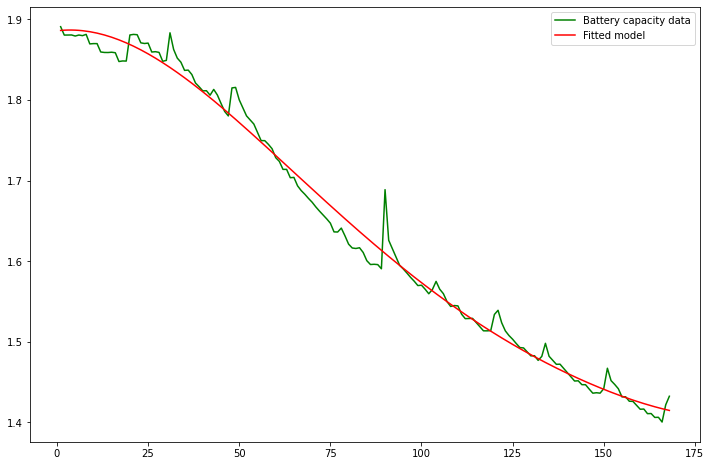

In [21]:
#print(y_pred.flatten())
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.plot(X, Y, color='green', label='Battery capacity data')
ax.plot(X, y_pred, color='red', label='Fitted model')
#ax.set(xlabel='Time in seconds', ylabel=label, title='Discharging performance at 43°C')
ax.legend()

# Circuit Visualization

In [22]:
from skqulacs.circuit.pre_defined import create_qcl_ansatz
from qulacsvis import circuit_drawer
from skqulacs.circuit.pre_defined import create_farhi_neven_ansatz

n_qubit = 5
c_depth = 3
ansatz = create_farhi_neven_ansatz(n_qubit, c_depth)
circuit_drawer(ansatz._circuit)

print(circuit_drawer(ansatz._circuit, "latex_source"))


###############################################################################
>> 0
   ___     ___                                                                 
  |pRY|   |pRZ|                                                                
--|   |---|   |-----------------------------------------------------●----------
  |___|   |___|                                                     |          
   ___     ___                                                      |          
  |pRY|   |pRZ|                                                     |          
--|   |---|   |-----------------------------------------------------|----------
  |___|   |___|                                                     |          
   ___     ___     ___     ___     ___     ___     ___     ___      |          
  |pRY|   |pRZ|   |CX |   |pRX|   |pRY|   |CX |   |pRY|   |pRX|     |          
--|   |---|   |---|   |---|   |---|   |---|   |---|   |---|   |-----|----------
  |___|   |___|   |___|   |___|   

In [23]:
from skqulacs.circuit.pre_defined import create_qcl_ansatz
from qulacsvis import circuit_drawer

n_qubit = 5
c_depth = 1
time_step = 1.
ansatz = create_qcl_ansatz(n_qubit, c_depth, time_step)
circuit_drawer(ansatz._circuit)

print(circuit_drawer(ansatz._circuit, "latex_source"))

   ___     ___     ___     ___     ___     ___   
  |pRY|   |pRZ|   |DeM|   |pRX|   |pRZ|   |pRX|  
--|   |---|   |---|   |---|   |---|   |---|   |--
  |___|   |___|   |   |   |___|   |___|   |___|  
   ___     ___    |   |    ___     ___     ___   
  |pRY|   |pRZ|   |   |   |pRX|   |pRZ|   |pRX|  
--|   |---|   |---|   |---|   |---|   |---|   |--
  |___|   |___|   |   |   |___|   |___|   |___|  
   ___     ___    |   |    ___     ___     ___   
  |pRY|   |pRZ|   |   |   |pRX|   |pRZ|   |pRX|  
--|   |---|   |---|   |---|   |---|   |---|   |--
  |___|   |___|   |   |   |___|   |___|   |___|  
   ___     ___    |   |    ___     ___     ___   
  |pRY|   |pRZ|   |   |   |pRX|   |pRZ|   |pRX|  
--|   |---|   |---|   |---|   |---|   |---|   |--
  |___|   |___|   |   |   |___|   |___|   |___|  
   ___     ___    |   |    ___     ___     ___   
  |pRY|   |pRZ|   |   |   |pRX|   |pRZ|   |pRX|  
--|   |---|   |---|   |---|   |---|   |---|   |--
  |___|   |___|   |___|   |___|   |___|   |___|  


In [27]:
from skqulacs.circuit.pre_defined import create_ibm_embedding_circuit

n_qubit = 3
circuit = create_ibm_embedding_circuit(n_qubit)
circuit_drawer(circuit._circuit)


###############################################################################
>> 0
   ___     ___                                                                 
  | H |   |pRZ|                                                                
--|   |---|   |-----●---------------●------------------------------------------
  |___|   |___|     |               |                                          
   ___             _|_     ___     _|_     ___                                 
  | H |           |CX |   |pRZ|   |CX |   |pRZ|                                
--|   |-----------|   |---|   |---|   |---|   |-----●---------------●----------
  |___|           |___|   |___|   |___|   |___|     |               |          
   ___                                             _|_     ___     _|_     ___ 
  | H |                                           |CX |   |pRZ|   |CX |   |pRZ|
--|   |-------------------------------------------|   |---|   |---|   |---|   |
  |___|                           

In [26]:
print(circuit_drawer(ansatz._circuit, "latex_source"))


\documentclass[border={-2pt 5pt 5pt -7pt}]{standalone}
\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
    \Qcircuit @C=1.0em @R=0.7em @!R{ \\
        \nghost{ q_{0} : } & \lstick{ q_{0} : } & \gate{pRY} & \gate{pRZ} & \qw & \qw & \qw & \qw & \multigate{4}{DeM} & \gate{pRX} & \gate{pRZ} & \gate{pRX} & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
        \nghost{ q_{1} : } & \lstick{ q_{1} : } & \qw & \gate{pRY} & \gate{pRZ} & \qw & \qw & \qw & \ghost{DeM} & \qw & \qw & \gate{pRX} & \gate{pRZ} & \gate{pRX} & \qw & \qw & \qw & \qw & \qw & \qw & \qw\\
        \nghost{ q_{2} : } & \lstick{ q_{2} : } & \qw & \qw & \gate{pRY} & \gate{pRZ} & \qw & \qw & \ghost{DeM} & \qw & \qw & \qw & \qw & \gate{pRX} & \gate{pRZ} & \gate{pRX} & \qw & \qw & \qw & \qw & \qw\\
        \nghost{ q_{3} : } & \lstick{ q_{3} : } & \qw & \qw & \qw & \gate{pRY} & \gate{pRZ} & \qw & \ghost{DeM} & \qw & \qw & \qw & \qw & \qw & \qw & \gate{pRX} & \gate{pRZ} & \gate{pRX} & \qw & \qw & \